# Important Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cpu')

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Recomendation System/ml-latest-small/ratings.csv")

In [6]:
df.info() # basically show schema

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
df.userId.nunique(),df.movieId.nunique()

(610, 9724)

In [9]:
df.rating.value_counts() #check value distribution

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [10]:
df.shape

(100836, 4)

# Training Dataset Class Wrapper


In [11]:
class MovieDataset:
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings
    # len(movie_dataset) overwriting length function
    def __len__(self):
        return len(self.users)
    # movie_dataset[1] return tensor of index 1 
    def __getitem__(self, item):

        users = self.users[item] 
        movies = self.movies[item]
        ratings = self.ratings[item]
        
        return {
            "users": torch.tensor(users, dtype=torch.long),
            "movies": torch.tensor(movies, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.long),
        }

# Create Model

In [13]:
class RecSysModel(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        
        # trainable lookup matrix for shallow embedding vectors
        # Each user is of 32 size vector
        self.user_embed = nn.Embedding(n_users, 32)
        self.movie_embed = nn.Embedding(n_movies, 32)
        # user, movie embedding concat
        # So, concatenated vector is of 64 bits and return output of size 1
        self.out = nn.Linear(64, 1)

    def forward(self, users, movies, ratings=None):
      # given user and movie find embedding of particular item
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)

      # concatenate the embedding
        output = torch.cat([user_embeds, movie_embeds], dim=1)
      # run an linear classifier over it
        output = self.out(output)
        
        return output

# Preprocessing

In [17]:
# encode the user and movie id to start from 0 so we don't run into index out of bound with Embedding
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
df.userId = lbl_user.fit_transform(df.userId.values)
df.movieId = lbl_movie.fit_transform(df.movieId.values)

# Train and Validation Split
df_train, df_valid = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.rating.values
)

train_dataset = MovieDataset(
    users=df_train.userId.values,
    movies=df_train.movieId.values,
    ratings=df_train.rating.values
)

valid_dataset = MovieDataset(
    users=df_valid.userId.values,
    movies=df_valid.movieId.values,
    ratings=df_valid.rating.values
)

In [19]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2) 

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2) 


In [20]:
dataiter = iter(train_loader)
dataloader_data = next(dataiter) 
print(dataloader_data)

<ipython-input-11-42ef46646a6b>:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),
<ipython-input-11-42ef46646a6b>:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),


{'users': tensor([285, 465, 603, 596]), 'movies': tensor([1052, 2544,  519,  932]), 'ratings': tensor([3, 4, 3, 4])}


In [21]:
model = RecSysModel(
    n_users=len(lbl_user.classes_),
    n_movies=len(lbl_movie.classes_),
).to(device)

optimizer = torch.optim.Adam(model.parameters())  
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

loss_func = nn.MSELoss()

In [22]:
print(len(lbl_user.classes_))
print(len(lbl_movie.classes_))
print(df.movieId.max())
print(len(train_dataset))

610
9724
9723
90752


## Manually checking forward pass

In [23]:
print(dataloader_data['users'])

print(dataloader_data['users'].size())
print(dataloader_data['movies'] )
print(dataloader_data['movies'].size())

user_embed = nn.Embedding(len(lbl_user.classes_), 32)
movie_embed = nn.Embedding(len(lbl_movie.classes_), 32)

out = nn.Linear(64, 1)


tensor([285, 465, 603, 596])
torch.Size([4])
tensor([1052, 2544,  519,  932])
torch.Size([4])


In [ ]:
user_embeds = user_embed(dataloader_data['users'])
movie_embeds = movie_embed(dataloader_data['movies'])
print(f"user_embeds {user_embeds.size()}")
print(f"user_embeds {user_embeds}")
print(f"movie_embeds {movie_embeds.size()}")
print(f"movie_embeds {movie_embeds}")

In [ ]:
output = torch.cat([user_embeds, movie_embeds], dim=1) 
print(f"output: {output.size()}")
print(f"output: {output}")
output = out(output)
print(f"output: {output}")

In [26]:
with torch.no_grad():
    model_output = model(dataloader_data['users'], 
                   dataloader_data["movies"])

    print(f"model_output: {model_output}, size: {model_output.size()}")

model_output: tensor([[ 0.0398],
        [-0.5056],
        [ 0.8880],
        [-0.3869]]), size: torch.Size([4, 1])



# Run the training loop

In [27]:
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = [] 

model.train() 
for epoch_i in range(epochs):
    for i, train_data in enumerate(train_loader):
        output = model(train_data["users"], 
                       train_data["movies"]
                      ) 
        
        # .view(4, -1) is to reshape the rating to match the shape of model output which is 4x1
        rating = train_data["ratings"].view(4, -1).to(torch.float32)

        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt = step_cnt + len(train_data["users"])
        

        if(step_cnt % plot_steps == 0):
            avg_loss = total_loss/(len(train_data["users"]) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0 # reset total_loss

<ipython-input-11-42ef46646a6b>:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),
<ipython-input-11-42ef46646a6b>:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),


epoch 0 loss at step: 5000 is 0.49517877912819386
epoch 0 loss at step: 10000 is 0.172490294226259
epoch 0 loss at step: 15000 is 0.10446575499996542
epoch 0 loss at step: 20000 is 0.0798221115227323
epoch 0 loss at step: 25000 is 0.07145914863720536
epoch 0 loss at step: 30000 is 0.06792958482615649
epoch 0 loss at step: 35000 is 0.06350215933872387
epoch 0 loss at step: 40000 is 0.06116453073634766
epoch 0 loss at step: 45000 is 0.06192633285596967
epoch 0 loss at step: 50000 is 0.06028910663262941
epoch 0 loss at step: 55000 is 0.058961487125791606
epoch 0 loss at step: 60000 is 0.059091142846574074
epoch 0 loss at step: 65000 is 0.05733335439199582
epoch 0 loss at step: 70000 is 0.05904408981082961
epoch 0 loss at step: 75000 is 0.05899379125246778
epoch 0 loss at step: 80000 is 0.0578816043141298
epoch 0 loss at step: 85000 is 0.056874139831308276
epoch 0 loss at step: 90000 is 0.05699914276748896


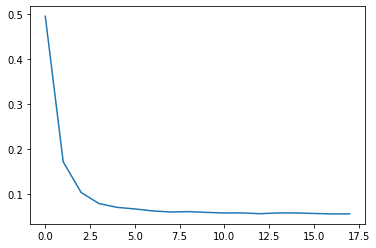

In [28]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

# Evaluation RMSE


In [29]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval()

with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        model_output = model(batched_data['users'], 
                       batched_data["movies"])
        
        model_output_list.append(model_output.sum().item() / len(batched_data['users']) )

        target_rating = batched_data["ratings"]
        
        target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))

        print(f"model_output: {model_output}, target_rating: {target_rating}")


# squared If True returns MSE value, if False returns RMSE value.
rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f"rms: {rms}")

<ipython-input-11-42ef46646a6b>:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),
<ipython-input-11-42ef46646a6b>:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),


Streaming output truncated to the last 5000 lines.
        [3.1007],
        [3.2000],
        [3.5940]]), target_rating: tensor([3, 4, 3, 2])
model_output: tensor([[2.6788],
        [2.7840],
        [4.1616],
        [3.4632]]), target_rating: tensor([3, 2, 4, 5])
model_output: tensor([[3.0783],
        [3.4857],
        [3.4363],
        [3.1201]]), target_rating: tensor([3, 3, 3, 4])
model_output: tensor([[2.9840],
        [3.8021],
        [2.7027],
        [2.6961]]), target_rating: tensor([3, 3, 5, 4])
model_output: tensor([[3.3614],
        [2.0317],
        [2.9859],
        [3.1993]]), target_rating: tensor([1, 2, 3, 3])
model_output: tensor([[3.9435],
        [2.9215],
        [4.2952],
        [3.1341]]), target_rating: tensor([2, 2, 5, 4])
model_output: tensor([[4.6510],
        [3.8270],
        [3.1479],
        [3.6228]]), target_rating: tensor([5, 4, 4, 4])
model_output: tensor([[2.4902],
        [3.4969],
        [3.2532],
        [4.2736]]), target_rating: tensor([2,

# Evaluation with Recall@K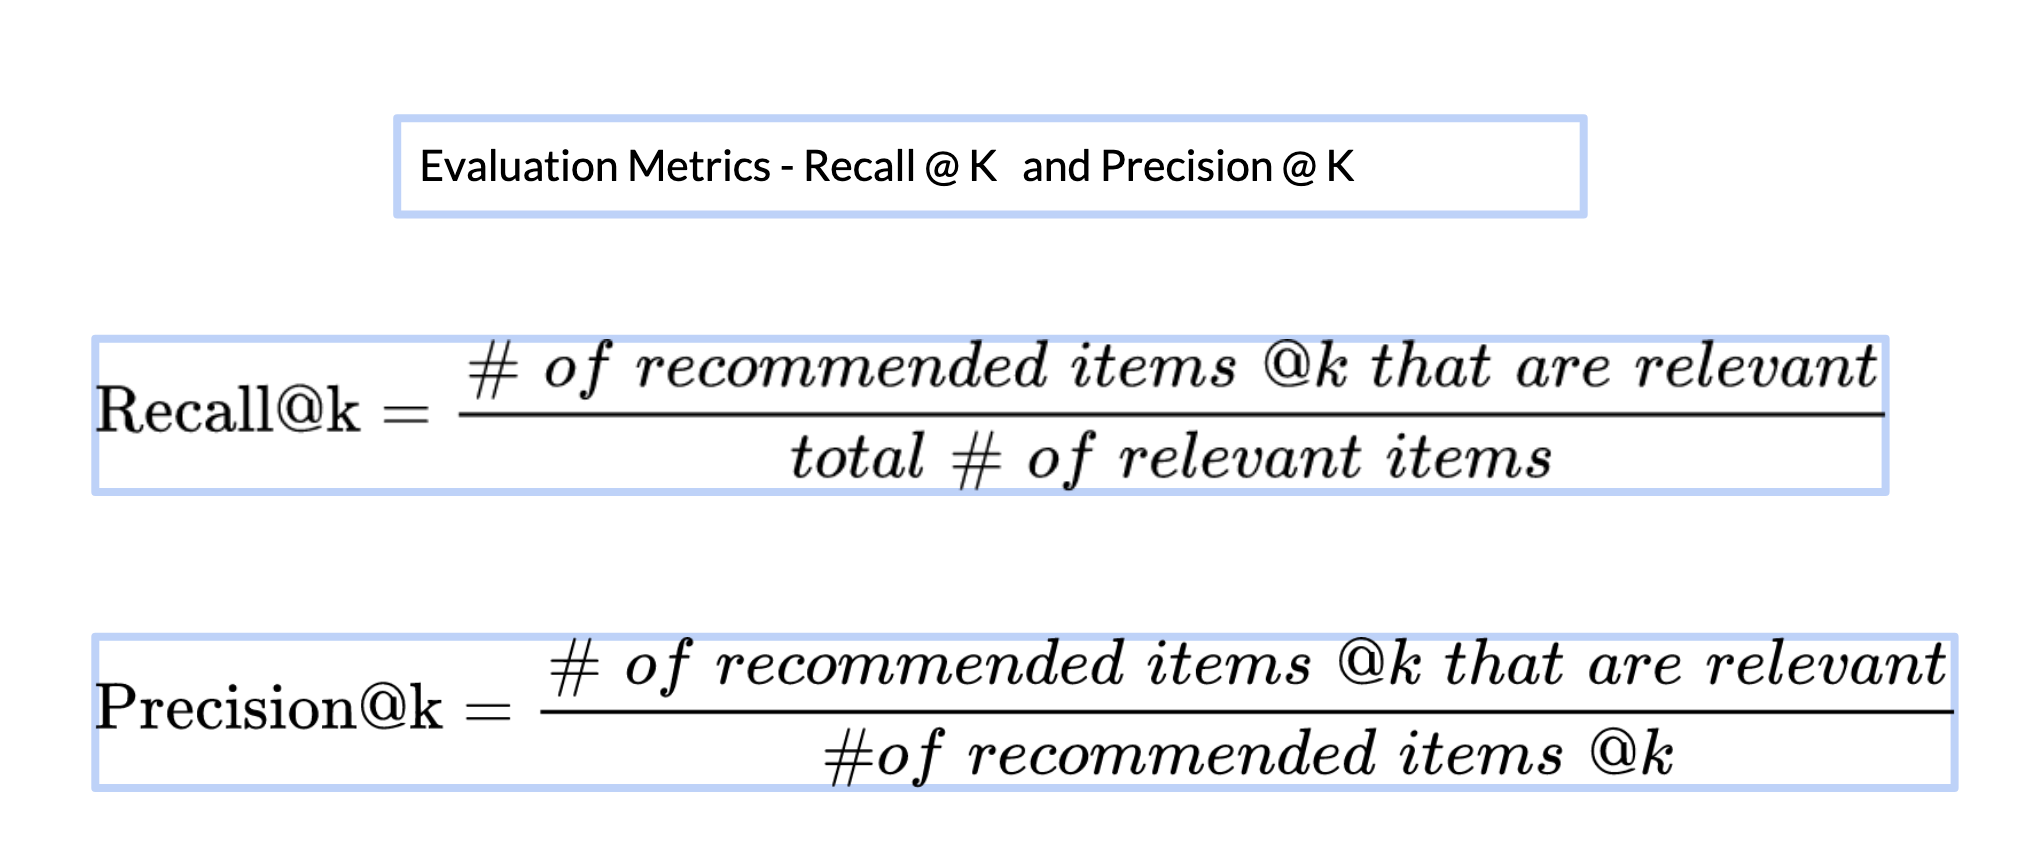

In [30]:
from collections import defaultdict

# a dict that stores a list of predicted rating and actual rating pair for each user 
user_est_true = defaultdict(list)

# iterate through the validation data to build the user-> [(y1, y1_hat), (y2, y2_hat)...]   
with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        users = batched_data['users']
        movies = batched_data['movies']
        ratings = batched_data['ratings']
        
        model_output = model(batched_data['users'], batched_data["movies"])

        for i in range(len(users)):
            user_id = users[i].item()
            movie_id = movies[i].item() 
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()
            
            print(f"{user_id}, {movie_id}, {pred_rating}, {true_rating}")
            user_est_true[user_id].append((pred_rating, true_rating))            


<ipython-input-11-42ef46646a6b>:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),
<ipython-input-11-42ef46646a6b>:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),


Streaming output truncated to the last 5000 lines.
367, 1700, 3.389986038208008, 2
551, 2353, 3.30708646774292, 4
201, 2631, 3.738863706588745, 4
483, 1583, 3.3465917110443115, 4
561, 6992, 3.4241585731506348, 3
143, 123, 3.545279026031494, 3
413, 579, 3.125683069229126, 2
325, 4607, 3.8873403072357178, 5
231, 7078, 3.019130229949951, 2
473, 4800, 2.837834358215332, 3
56, 1495, 3.0317323207855225, 2
598, 4601, 2.625864028930664, 3
273, 2042, 2.531538248062134, 3
336, 162, 3.6416423320770264, 5
88, 506, 3.559528112411499, 1
245, 5379, 3.8845112323760986, 4
609, 507, 4.1656951904296875, 5
602, 1649, 3.7708802223205566, 5
306, 701, 2.950270175933838, 5
576, 97, 3.7758100032806396, 4
451, 968, 4.619877815246582, 4
27, 6046, 2.825723648071289, 2
225, 2440, 3.2073471546173096, 3
404, 6563, 3.604203701019287, 4
220, 965, 3.670048236846924, 4
598, 5607, 2.203904151916504, 2
103, 3617, 3.9961695671081543, 5
544, 1825, 2.8817298412323, 4
519, 819, 4.4636030197143555, 4
355, 819, 4.14196109771728

In [31]:
with torch.no_grad():
    precisions = dict()
    recalls = dict()

    k=10
    threshold=3.5

    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value. 
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # get the number of actual relevant item
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # get the number of recommended item that are predicted relevent and within topk
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # get the number of recommented item that' is also actually relevant within topk
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        print(f"uid {uid},  n_rel {n_rel}, n_rec_k {n_rec_k}, n_rel_and_rec_k {n_rel_and_rec_k}")

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

uid 389,  n_rel 8, n_rec_k 6, n_rel_and_rec_k 5
uid 220,  n_rel 24, n_rec_k 10, n_rel_and_rec_k 8
uid 316,  n_rel 14, n_rec_k 10, n_rel_and_rec_k 7
uid 285,  n_rel 4, n_rec_k 3, n_rel_and_rec_k 3
uid 231,  n_rel 24, n_rec_k 3, n_rel_and_rec_k 3
uid 379,  n_rel 66, n_rec_k 10, n_rel_and_rec_k 8
uid 482,  n_rel 49, n_rec_k 10, n_rel_and_rec_k 7
uid 609,  n_rel 70, n_rec_k 10, n_rel_and_rec_k 9
uid 273,  n_rel 28, n_rec_k 10, n_rel_and_rec_k 5
uid 452,  n_rel 23, n_rec_k 10, n_rel_and_rec_k 9
uid 108,  n_rel 1, n_rec_k 0, n_rel_and_rec_k 0
uid 338,  n_rel 22, n_rec_k 10, n_rel_and_rec_k 5
uid 209,  n_rel 14, n_rec_k 10, n_rel_and_rec_k 8
uid 134,  n_rel 16, n_rec_k 10, n_rel_and_rec_k 8
uid 306,  n_rel 18, n_rec_k 0, n_rel_and_rec_k 0
uid 9,  n_rel 2, n_rec_k 1, n_rel_and_rec_k 0
uid 513,  n_rel 22, n_rec_k 2, n_rel_and_rec_k 2
uid 67,  n_rel 42, n_rec_k 10, n_rel_and_rec_k 6
uid 267,  n_rel 4, n_rec_k 5, n_rel_and_rec_k 2
uid 178,  n_rel 2, n_rec_k 4, n_rel_and_rec_k 2
uid 248,  n_rel 56